# Data Science Project: Fuel Price Prediction Model

### 3-Sentence summary of full project:

We build a route-aware refueling recommender for Germany that forecasts station-level prices at the ETA and then optimizes “where/when to stop (and how much to buy)” by trading cheaper price vs. detour/time and fuel constraints. The pipeline ingests historical + live data, enriches with routing/ETA, weather, holidays, and macro signals, and serves uncertainty-aware recommendations via a FastAPI backend and an interactive Streamlit map. Everything is fully automated, validated, and documented in a reproducible repo, with the app hosted on the bwCloud.

## Data Preparation

In [ ]:
import duckdb
from pathlib import Path

# Base directory of the cloned tankerkoenig-data repo
BASE_DIR = Path(
    r"C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data"
)

# DuckDB database file (will be created if it does not exist)
DB_PATH = BASE_DIR / "fuel_price_preparation.duckdb"

con = duckdb.connect(DB_PATH.as_posix())
con.execute("PRAGMA threads=8;")       # use multiple cores if available
con.execute("SELECT setseed(0.42)")  # fixed seed for reproducible random sampling

print(f"Connected to DuckDB at: {DB_PATH}")

In [ ]:
# Globs for 2023/2024 prices and stations
prices_2023_glob = (BASE_DIR / "prices" / "2023" / "*" / "*-prices.csv").as_posix()
prices_2024_glob = (BASE_DIR / "prices" / "2024" / "*" / "*-prices.csv").as_posix()

stations_2023_glob = (BASE_DIR / "stations" / "2023" / "*" / "*-stations.csv").as_posix()
stations_2024_glob = (BASE_DIR / "stations" / "2024" / "*" / "*-stations.csv").as_posix()

print(prices_2023_glob)
print(prices_2024_glob)
print(stations_2023_glob)
print(stations_2024_glob)

In [ ]:
# 2.1 Prices: read 2023 + 2024 into one table
con.execute("DROP TABLE IF EXISTS prices_raw;")
con.execute(
    """
    CREATE TABLE prices_raw AS
    SELECT * FROM read_csv_auto(?, SAMPLE_SIZE=-1)
    UNION ALL
    SELECT * FROM read_csv_auto(?, SAMPLE_SIZE=-1);
    """,
    [prices_2023_glob, prices_2024_glob],
)

# Quick sanity check
con.execute("SELECT COUNT(*) AS n_rows, MIN(date), MAX(date) FROM prices_raw;").df()

In [ ]:
# 2.2 Stations: read 2023 + 2024 into one table, also keep filename
con.execute("DROP TABLE IF EXISTS stations_raw;")
con.execute(
    """
    CREATE TABLE stations_raw AS
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        city,
        latitude,
        longitude,
        first_active,
        openingtimes_json,
        filename
    FROM read_csv_auto(
            ?, 
            SAMPLE_SIZE=-1, 
            filename=true, 
            union_by_name=true
         )
    UNION ALL
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        city,
        latitude,
        longitude,
        first_active,
        openingtimes_json,
        filename
    FROM read_csv_auto(
            ?, 
            SAMPLE_SIZE=-1, 
            filename=true, 
            union_by_name=true
         );
    """,
    [stations_2023_glob, stations_2024_glob],
)

con.execute(
    "SELECT COUNT(*) AS n_rows, MIN(uuid) AS min_uuid, MAX(uuid) AS max_uuid FROM stations_raw;"
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# 3.1 Pick latest snapshot per station within 2023–2024
con.execute("DROP TABLE IF EXISTS stations_snapshot;")
con.execute(
    """
    CREATE TABLE stations_snapshot AS
    WITH parsed AS (
        SELECT
            *,
            -- extract 'YYYY-MM-DD' from filename, e.g. '.../2023-01-01-stations.csv'
            CAST(regexp_extract(filename, '([0-9]{4}-[0-9]{2}-[0-9]{2})', 1) AS DATE) AS snapshot_date
        FROM stations_raw
    ),
    ranked AS (
        SELECT
            *,
            ROW_NUMBER() OVER (PARTITION BY uuid ORDER BY snapshot_date DESC) AS rn
        FROM parsed
    )
    SELECT
        uuid,
        name,
        brand,
        street,
        house_number,
        city,
        CAST(latitude AS DOUBLE)  AS latitude,
        CAST(longitude AS DOUBLE) AS longitude,
        first_active,
        openingtimes_json
    FROM ranked
    WHERE rn = 1;
    """
)

con.execute(
    "SELECT COUNT(*) AS n_rows, COUNT(DISTINCT uuid) AS n_uuids FROM stations_snapshot;"
).df()

In [ ]:
# 3.2 Sample 500 random stations and compute brand groups (rare brands -> 'other')
con.execute("DROP TABLE IF EXISTS stations_sampled;")
con.execute(
    """
    CREATE TABLE stations_sampled AS
    WITH ranked AS (
        SELECT
            uuid,
            brand,
            city,
            row_number() OVER (ORDER BY random()) AS rn
        FROM stations_snapshot
    )
    SELECT
        uuid,
        brand,
        city
    FROM ranked
    WHERE rn <= 500;
    """
)

# Brand grouping: brands with <= 5 stations in the 500-sample are mapped to 'other'
con.execute("DROP TABLE IF EXISTS stations_sampled_grouped;")
con.execute(
    """
    CREATE TABLE stations_sampled_grouped AS
    WITH brand_counts AS (
        SELECT brand, COUNT(*) AS n
        FROM stations_sampled
        GROUP BY brand
    ),
    extended AS (
        SELECT
            s.uuid,
            s.city,
            CASE WHEN bc.n > 5 THEN s.brand ELSE 'other' END AS brand_group
        FROM stations_sampled s
        LEFT JOIN brand_counts bc USING (brand)
    )
    SELECT * FROM extended;
    """
)

con.execute(
    """
    SELECT brand_group, COUNT(*) AS n_stations
    FROM stations_sampled_grouped
    GROUP BY brand_group
    ORDER BY n_stations DESC;
    """
).df()

In [ ]:
# 4.1 E5 price changes for the 500 sampled stations
con.execute("DROP TABLE IF EXISTS prices_sampled_e5;")
con.execute(
    """
    CREATE TABLE prices_sampled_e5 AS
    SELECT
        CAST(p.date AS TIMESTAMP) AS ts,
        p.station_uuid,
        CAST(p.e5 AS DOUBLE) AS price_e5
    FROM prices_raw p
    JOIN stations_sampled_grouped s
        ON s.uuid = p.station_uuid
    WHERE p.e5 IS NOT NULL
      AND p.e5 > 0;
    """
)

con.execute(
    """
    SELECT COUNT(*) AS n_rows, MIN(ts) AS min_ts, MAX(ts) AS max_ts
    FROM prices_sampled_e5;
    """
).df()

In [ ]:
# 4.2 Round timestamps down to the nearest 30-minute grid cell
con.execute("DROP TABLE IF EXISTS prices_sampled_e5_rounded;")
con.execute(
    """
    CREATE TABLE prices_sampled_e5_rounded AS
    SELECT
        station_uuid,
        -- floor to 30-minute grid: 00 or 30
        date_trunc('hour', ts)
            + INTERVAL (CASE WHEN EXTRACT(MINUTE FROM ts) < 30 THEN 0 ELSE 30 END) MINUTE AS ts_30,
        AVG(price_e5) AS price_e5
    FROM prices_sampled_e5
    GROUP BY station_uuid, ts_30;
    """
)

con.execute(
    """
    SELECT COUNT(*) AS n_rows,
           MIN(ts_30) AS min_ts_30,
           MAX(ts_30) AS max_ts_30
    FROM prices_sampled_e5_rounded;
    """
).df()

In [ ]:
con.execute("DROP TABLE IF EXISTS grid_sampled_e5;")
con.execute(
    """
    CREATE TABLE grid_sampled_e5 AS
    WITH station_span AS (
        SELECT
            station_uuid,
            MIN(ts_30) AS min_ts,
            MAX(ts_30) AS max_ts
        FROM prices_sampled_e5_rounded
        GROUP BY station_uuid
    ),
    grid AS (
        -- 30-minute grid per station from first to last observed change
        SELECT
            s.station_uuid,
            gs.ts_30
        FROM station_span s,
        generate_series(
            s.min_ts,
            s.max_ts,
            INTERVAL 30 MINUTE
        ) AS gs(ts_30)
    ),
    base AS (
        -- attach price events (may be NULL if no change in this grid cell)
        SELECT
            g.station_uuid,
            g.ts_30,
            pr.price_e5 AS price_event
        FROM grid g
        LEFT JOIN prices_sampled_e5_rounded pr
          ON pr.station_uuid = g.station_uuid
         AND pr.ts_30       = g.ts_30
    ),
    numbered AS (
        -- sequential index per station for forward-fill logic
        SELECT
            station_uuid,
            ts_30,
            price_event,
            ROW_NUMBER() OVER (
                PARTITION BY station_uuid
                ORDER BY ts_30
            ) AS k
        FROM base
    ),
    with_last_k AS (
        -- for each row, compute index of last row with a non-null price_event
        SELECT
            station_uuid,
            ts_30,
            k,
            MAX(
                CASE
                    WHEN price_event IS NOT NULL THEN k
                    ELSE NULL
                END
            ) OVER (
                PARTITION BY station_uuid
                ORDER BY k
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            ) AS last_k
        FROM numbered
    ),
    ff AS (
        -- join back to get the forward-filled price
        SELECT
            n.station_uuid,
            n.ts_30,
            e.price_event AS price_e5
        FROM with_last_k n
        LEFT JOIN numbered e
          ON e.station_uuid = n.station_uuid
         AND e.k           = n.last_k
    )
    SELECT *
    FROM ff
    WHERE price_e5 IS NOT NULL;
    """
)

con.execute(
    """
    SELECT COUNT(*) AS n_rows,
           MIN(ts_30) AS min_ts_30,
           MAX(ts_30) AS max_ts_30
    FROM grid_sampled_e5;
    """
).df()

In [ ]:
con.execute("DROP TABLE IF EXISTS grid_sampled_e5_prepared;")
con.execute(
    """
    CREATE TABLE grid_sampled_e5_prepared AS
    SELECT
        station_uuid,
        ts_30 AS ts,
        CAST(ts_30 AS DATE) AS d,  -- calendar date
        (EXTRACT(HOUR FROM ts_30) * 2 + EXTRACT(MINUTE FROM ts_30) / 30) AS time_cell,  -- 0..47
        price_e5 AS price
    FROM grid_sampled_e5;
    """
)

con.execute(
    """
    SELECT
        MIN(d) AS min_date,
        MAX(d) AS max_date,
        MIN(time_cell) AS min_cell,
        MAX(time_cell) AS max_cell
    FROM grid_sampled_e5_prepared;
    """
).df()

In [ ]:
con.execute("DROP TABLE IF EXISTS features_raw;")
con.execute(
    """
    CREATE TABLE features_raw AS
    SELECT
        g.station_uuid,
        g.d,
        g.time_cell,
        g.price AS price_today,
        y.price AS price_yesterday,
        w.price AS price_weekago
    FROM grid_sampled_e5_prepared g
    LEFT JOIN grid_sampled_e5_prepared y
        ON y.station_uuid = g.station_uuid
       AND y.time_cell   = g.time_cell
       AND y.d           = g.d - INTERVAL 1 DAY
    LEFT JOIN grid_sampled_e5_prepared w
        ON w.station_uuid = g.station_uuid
       AND w.time_cell   = g.time_cell
       AND w.d           = g.d - INTERVAL 7 DAY;
    """
)

con.execute(
    """
    SELECT
        COUNT(*) AS n_rows,
        SUM(
            CASE
                WHEN price_yesterday IS NOT NULL AND price_weekago IS NOT NULL
                THEN 1 ELSE 0
            END
        ) AS n_complete
    FROM features_raw;
    """
).df()

In [ ]:
con.execute("DROP TABLE IF EXISTS features_sampled_e5;")
con.execute(
    """
    CREATE TABLE features_sampled_e5 AS
    SELECT
        f.station_uuid,
        f.d AS date,
        f.time_cell,
        f.price_today    AS price,
        f.price_yesterday,
        f.price_weekago,
        sb.brand_group,
        EXTRACT(DOW FROM f.d) AS day_of_week  -- 0=Sunday ... 6=Saturday
    FROM features_raw f
    JOIN stations_sampled_grouped sb
        ON sb.uuid = f.station_uuid
    WHERE f.price_yesterday IS NOT NULL
      AND f.price_weekago  IS NOT NULL;
    """
)

con.execute(
    """
    SELECT
        COUNT(*) AS n_rows,
        MIN(date) AS min_date,
        MAX(date) AS max_date
    FROM features_sampled_e5;
    """
).df()

In [ ]:
sample_df = con.execute(
    """
    SELECT *
    FROM features_sampled_e5
    ORDER BY date, time_cell, station_uuid
    LIMIT 20;
    """
).df()

sample_df

In [ ]:
# --- 3.x Export enriched features (with market) to Parquet ---
output_dir = BASE_DIR / "derived"
output_dir.mkdir(exist_ok=True)

output_parquet = output_dir / "features_sampled_e5_market_2023_2024.parquet"

sql = f"""
COPY features_sampled_e5_market
TO '{output_parquet.as_posix()}'
(FORMAT PARQUET, COMPRESSION ZSTD);
"""

con.execute(sql)

print(f"Exported features with market to: {output_parquet}")

## Model training

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Path to enriched features parquet
BASE_DIR = Path(
    r"C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data"
)
features_path = BASE_DIR / "derived" / "features_berlin_e5_market_2023_2024.parquet"

df = pd.read_parquet(features_path)
print(df.shape)
df.head()

In [ ]:
# Cast dtypes for clarity / efficiency
df["date"] = pd.to_datetime(df["date"])
df["time_cell"] = df["time_cell"].astype("int16")
df["day_of_week"] = df["day_of_week"].astype("int8")
df["post_code"] = df["post_code"].astype(str)

# Optional: sort by time (not strictly needed but nice to have)
df = df.sort_values(["date", "time_cell", "station_uuid"]).reset_index(drop=True)

df.dtypes

In [ ]:
# --- NEW: intraday last-price feature (per station & day) ---

# make sure rows are ordered correctly
df = df.sort_values(["station_uuid", "date", "time_cell"]).reset_index(drop=True)

# price in the *previous* time cell on the same day for the same station
df["price_intraday_prev"] = (
    df
    .groupby(["station_uuid", "date"])["price"]
    .shift(1)
)

# simple and safe missing-value handling:
# for the first time_cell of each day there is no "previous cell"
# -> fall back to yesterday's price at this time_cell
df["price_intraday_prev"] = df["price_intraday_prev"].fillna(df["price_yesterday"])

# optional: ensure numeric type consistent with other price features
df["price_intraday_prev"] = df["price_intraday_prev"].astype("float32")

In [ ]:
# Define cut dates
train_end = pd.Timestamp("2024-06-30")
valid_end = pd.Timestamp("2024-09-30")

train_mask = df["date"] <= train_end
valid_mask = (df["date"] > train_end) & (df["date"] <= valid_end)
test_mask  = df["date"] > valid_end

print("Train rows:", train_mask.sum())
print("Valid rows:", valid_mask.sum())
print("Test rows :", test_mask.sum())

In [ ]:
# --- Define target and features ---

target_col = "price"

feature_cols = [
    "time_cell",
    "day_of_week",
    "post_code",
    "brand_group",
    "price_intraday_prev",   # NEW: intraday last price (same day, same station)
    "price_yesterday",
    "price_weekago",
    "market_yesterday",
    "market_weekago",
    "markup_yesterday",
    "markup_weekago",
]

cat_cols = ["brand_group", "post_code"]  # categorical for LightGBM

# --- Time-based train/validation/test split (as before) ---

train_end = pd.Timestamp("2024-06-30")
valid_end = pd.Timestamp("2024-09-30")

train_mask = df["date"] <= train_end
valid_mask = (df["date"] > train_end) & (df["date"] <= valid_end)
test_mask  = df["date"] > valid_end

print("Train rows:", train_mask.sum())
print("Valid rows:", valid_mask.sum())
print("Test rows :", test_mask.sum())

X_train = df.loc[train_mask, feature_cols].copy()
y_train = df.loc[train_mask, target_col].values

X_valid = df.loc[valid_mask, feature_cols].copy()
y_valid = df.loc[valid_mask, target_col].values

X_test  = df.loc[test_mask,  feature_cols].copy()
y_test  = df.loc[test_mask,  target_col].values

# Cast categoricals
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_valid[c] = X_valid[c].astype("category")
    X_test[c]  = X_test[c].astype("category")

X_train.head()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mae_rmse(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # always returns MSE
    rmse = np.sqrt(mse)
    return mae, rmse

# Baseline 1: yesterday same time
b1_pred = df.loc[test_mask, "price_yesterday"].values
b1_mae, b1_rmse = mae_rmse(y_test, b1_pred)

# Baseline 2: week-ago same time
b2_pred = df.loc[test_mask, "price_weekago"].values
b2_mae, b2_rmse = mae_rmse(y_test, b2_pred)

# Baseline 3: simple average of yesterday and week-ago
b3_pred = 0.5 * (df.loc[test_mask, "price_yesterday"].values +
                 df.loc[test_mask, "price_weekago"].values)
b3_mae, b3_rmse = mae_rmse(y_test, b3_pred)

print("Baseline metrics on TEST set")
print(f"Yesterday:   MAE={b1_mae:.4f}, RMSE={b1_rmse:.4f}")
print(f"Week-ago:    MAE={b2_mae:.4f}, RMSE={b2_rmse:.4f}")
print(f"Avg(y,7d):   MAE={b3_mae:.4f}, RMSE={b3_rmse:.4f}")

In [28]:
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_cols,
    free_raw_data=False,
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=cat_cols,
    reference=train_data,
    free_raw_data=False,
)

params = {
    "objective": "mae",      # L1 regression
    "metric": "mae",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 200,
    "max_bin": 255,
    "verbosity": -1,
    "seed": 42,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),
    lgb.log_evaluation(period=50),  # optional: log every 50 iters
]

gbm = lgb.train(
    params,
    train_set=train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=callbacks,
)

[500]	train's l1: 0.00859377	valid's l1: 0.0100287
[550]	train's l1: 0.00854608	valid's l1: 0.00998518
[600]	train's l1: 0.0084804	valid's l1: 0.00995833
[650]	train's l1: 0.00842178	valid's l1: 0.00993598
[700]	train's l1: 0.00836498	valid's l1: 0.00991473
[750]	train's l1: 0.00830995	valid's l1: 0.00989741
[800]	train's l1: 0.0082775	valid's l1: 0.0098961
[850]	train's l1: 0.00824449	valid's l1: 0.00990211
[900]	train's l1: 0.00820365	valid's l1: 0.00988912
[950]	train's l1: 0.00817649	valid's l1: 0.00988452
[1000]	train's l1: 0.00814132	valid's l1: 0.0098868
Early stopping, best iteration is:
[928]	train's l1: 0.00818846	valid's l1: 0.00987873


In [29]:
# Use the best iteration determined by early stopping
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

lgb_mae, lgb_rmse = mae_rmse(y_test, y_pred_test)

print("LightGBM metrics on TEST set")
print(f"LightGBM:    MAE={lgb_mae:.4f}, RMSE={lgb_rmse:.4f}")

print("\nComparison:")
print(f"Yesterday:   MAE={b1_mae:.4f}, RMSE={b1_rmse:.4f}")
print(f"Week-ago:    MAE={b2_mae:.4f}, RMSE={b2_rmse:.4f}")
print(f"Avg(y,7d):   MAE={b3_mae:.4f}, RMSE={b3_rmse:.4f}")

LightGBM metrics on TEST set
LightGBM:    MAE=0.0100, RMSE=0.0160

Comparison:
Yesterday:   MAE=0.0130, RMSE=0.0215
Week-ago:    MAE=0.0223, RMSE=0.0310
Avg(y,7d):   MAE=0.0155, RMSE=0.0219


price_intraday_prev 118853206.6
price_yesterday 56064555.4
time_cell       14094319.5
price_weekago   7925088.5
markup_yesterday 3672803.8
markup_weekago  3025988.4
post_code       2962888.7
day_of_week     2041642.2
market_yesterday 844446.2
market_weekago  670141.6
brand_group     655956.6


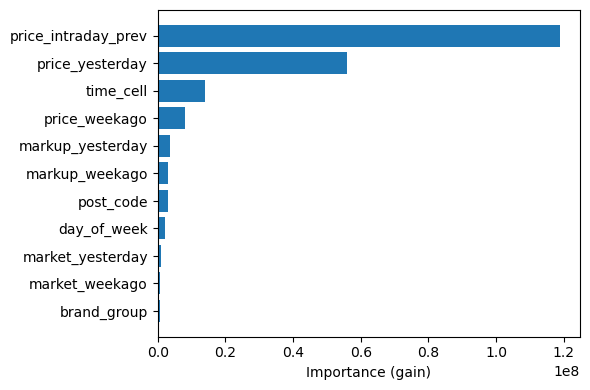

In [30]:
# Feature importances
import matplotlib.pyplot as plt

importances = gbm.feature_importance(importance_type="gain")
for col, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{col:15s} {imp:.1f}")

# Simple bar plot
plt.figure(figsize=(6, 4))
order = np.argsort(importances)
plt.barh(np.array(feature_cols)[order], importances[order])
plt.xlabel("Importance (gain)")
plt.tight_layout()
plt.show()

In [31]:
# Save model to disk for later use
model_path = BASE_DIR / "derived" / "lightgbm_berlin_e5_mae.txt"
gbm.save_model(model_path.as_posix())
print(f"Saved LightGBM model to: {model_path}")

Saved LightGBM model to: C:\Users\websi\OneDrive - UT Cloud\Semester\3. WS2025_26\DS500 Data Science Project (12 ECTS)\tankerkoenig_repo\tankerkoenig-data\derived\lightgbm_berlin_e5_mae.txt
